In [1]:
import os
import PIL
from PIL import Image
import json
from glob import glob
import re

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import cv2

In [9]:
root = "/mnt/nvme12TB/DATASETS-MANAGED/OCR/ocr_plates_raw"

In [10]:
paths = glob(f'{root}/imgs/*/*')

In [11]:
anns = glob(f'{root}/annotations/*')

In [12]:
with open(f'{root}/annotations/global_ann.json', 'r') as f:
    ann = json.load(f)

In [13]:
len(ann)

20646

In [76]:
df = pd.DataFrame(ann)

In [77]:
df.plate_type.value_counts(1)

Region3           0.732878
Region2           0.207692
Unknown           0.022958
Foreign           0.012787
Bus               0.010268
Trailer           0.007798
Region3\n         0.001744
Military          0.001405
Belarus           0.000823
DiplomatInvert    0.000823
Police            0.000436
Transit           0.000387
Name: plate_type, dtype: float64

In [93]:
plate_regex = r'^[а-я]\d{3}[а-я]{2}\d{2,3}$'

In [79]:
pattern = re.compile(plate_regex)

In [80]:
def is_valid_plate(text: str) -> bool:
    return bool(pattern.match(text))

In [94]:
# df = df[df['is_valid']]

In [95]:
df = df.rename(columns={'file_name': 'filename', 'plate_text': 'label'})

In [96]:
"".join(sorted(set("".join(df.label.values))))

'*-0123456789bdfgjlmnstvwавекмнорстух'

In [97]:
translation_table = str.maketrans('acehkopxy', 'асенкорху')

In [98]:
df['label'] = df['label'].apply(lambda x: x.lower().translate(translation_table))

In [99]:
"".join(sorted(set("".join(df.label.values))))

'*-0123456789bdfgjlmnstvwавекмнорстух'

In [100]:
df['is_valid'] = df['label'].apply(is_valid_plate)

In [101]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20646 entries, 0 to 20645
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20646 non-null  int64 
 1   filename    20646 non-null  object
 2   area        20646 non-null  int64 
 3   label       20646 non-null  object
 4   plate_type  20646 non-null  object
 5   car_id      20646 non-null  int64 
 6   height      20646 non-null  int64 
 7   width       20646 non-null  int64 
 8   is_valid    20646 non-null  bool  
dtypes: bool(1), int64(5), object(3)
memory usage: 1.3+ MB


,id,area,car_id,height,width
count,20646.000000,20646.000000,20646.000000,20646.000000,20646.000000
mean,10322.500000,2875.037586,685.010462,24.141529,106.291098
std,5960.131165,2341.469187,396.018230,8.749346,37.614432
min,0.000000,256.000000,0.000000,9.000000,16.000000
25%,5161.250000,1445.000000,361.000000,18.000000,80.000000
50%,10322.500000,2116.000000,655.000000,22.000000,95.000000
75%,15483.750000,3348.000000,1018.000000,28.000000,121.000000
max,20645.000000,24332.000000,1541.000000,79.000000,308.000000


In [102]:
"".join(sorted(set("".join(df[df.is_valid].label.values))))

'0123456789авекмнорстух'

In [103]:
# в среднем уникальных машин
len(df) / df.car_id.nunique()

13.38910505836576

In [24]:
df.head(3)

,id,filename,area,label,plate_type,car_id,height,width,is_valid
0,0,Day_00004_19.03.20/Day_00004_19.03.20.0_0.bmp,1743,с470ав799,Region3,0,21,83,True
1,1,Day_00004_19.03.20/Day_00004_19.03.20.1_0.bmp,1978,с470ав799,Region3,0,23,86,True
2,2,Day_00004_19.03.20/Day_00004_19.03.20.1_1.bmp,1120,е468тр750,Region3,1,14,80,True


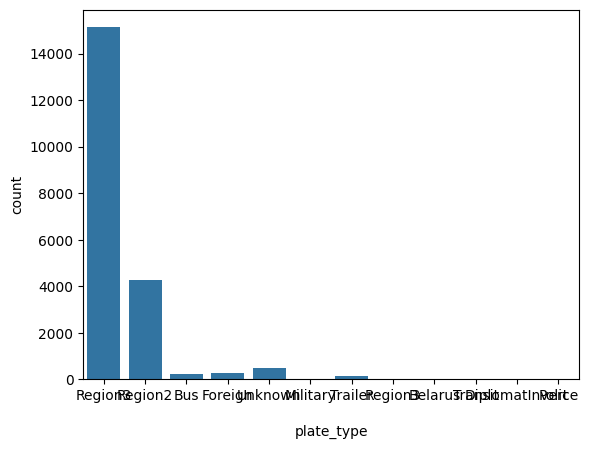

In [25]:
# Визуализация распределения типов табличек
sns.countplot(data=df, x='plate_type')
plt.show()

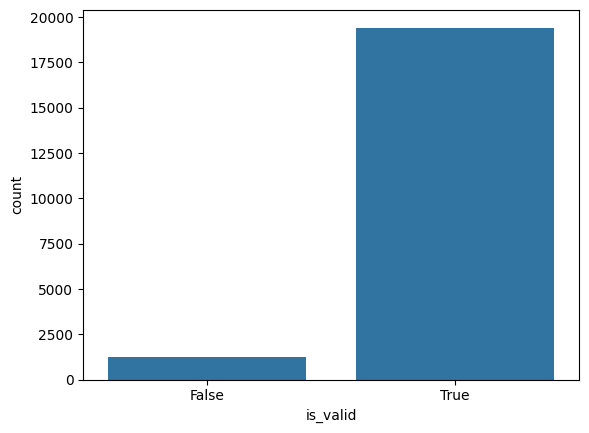

In [26]:
# Визуализация распределения типов табличек
sns.countplot(data=df, x='is_valid')
plt.show()

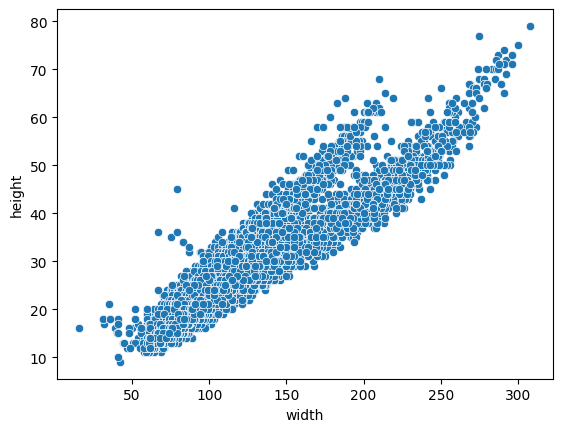

In [27]:
sns.scatterplot(data=df, x='width', y='height')
plt.show()

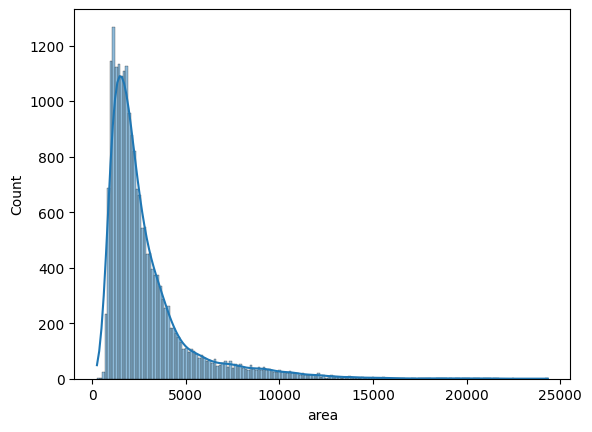

In [28]:
# Визуализация распределения областей
sns.histplot(data=df, x='area', kde=True)
plt.show()

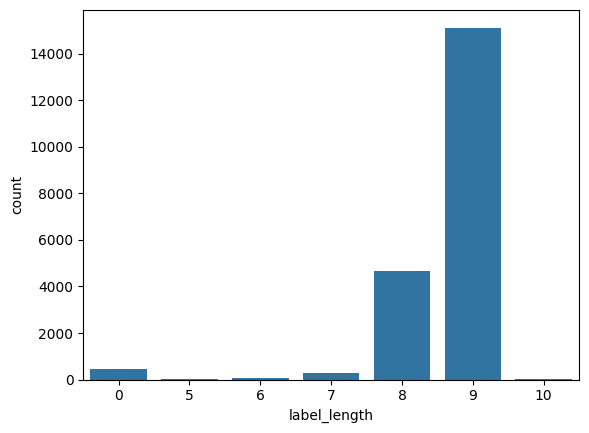

In [29]:
df['label_length'] = df['label'].apply(len)

# Визуализация распределения числа символов в метке
sns.countplot(data=df, x='label_length')
plt.show()

In [30]:
print(f'Alphabet: {"".join(sorted(set("".join(df.label.values))))}')

Alphabet: *-0123456789ABCGHJMNSWabcdefgjklmnopstvwАНТХавекмнорстух


In [31]:
print(f'Valid alphabet: {"".join(sorted(set("".join(df[df.is_valid].label.values))))}')

Valid alphabet: 0123456789ТХавекмнорстух


In [32]:
all_labels = ''.join(df['label'])
char_counts = Counter(all_labels)

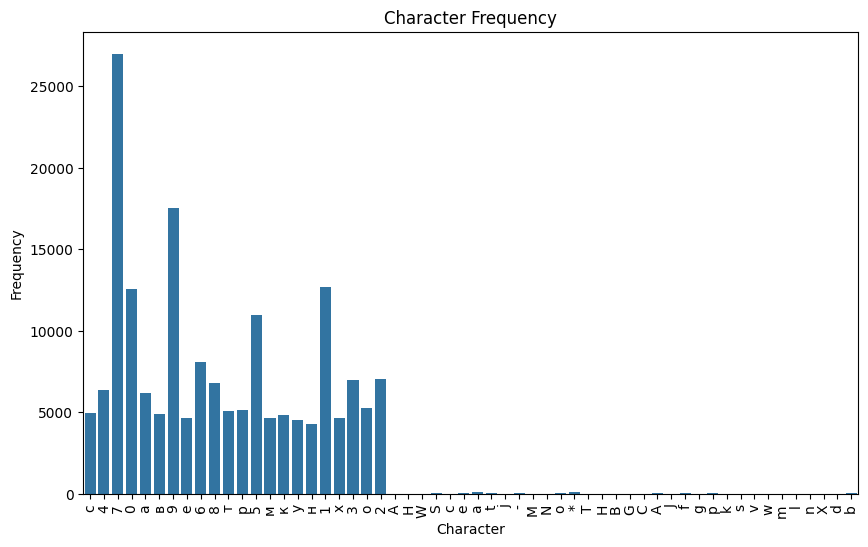

In [33]:
char_df = pd.DataFrame.from_dict(char_counts, orient='index', columns=['count']).reset_index()

# Визуализация частот символов
plt.figure(figsize=(10,6))
sns.barplot(data=char_df, x='index', y='count')
plt.title('Character Frequency')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [34]:
def display_images_grid(paths, labels):
    paths = paths[:16]
    labels = labels[:16]
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    axs = axs.ravel()

    for i, (label, path) in enumerate(zip(labels, paths)):
        img = cv2.imread(path)
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

In [35]:
df

,id,filename,area,label,plate_type,car_id,height,width,is_valid,label_length
0,0,Day_00004_19.03.20/Day_00004_19.03.20.0_0.bmp,1743,с470ав799,Region3,0,21,83,True,9
1,1,Day_00004_19.03.20/Day_00004_19.03.20.1_0.bmp,1978,с470ав799,Region3,0,23,86,True,9
2,2,Day_00004_19.03.20/Day_00004_19.03.20.1_1.bmp,1120,е468тр750,Region3,1,14,80,True,9
3,3,Day_00004_19.03.20/Day_00004_19.03.20.2_0.bmp,1246,с470ав799,Region3,0,14,89,True,9
4,4,Day_00004_19.03.20/Day_00004_19.03.20.2_1.bmp,1230,е468тр750,Region3,1,15,82,True,9
...,...,...,...,...,...,...,...,...,...,...
20641,20641,Urm-vs-Sipm/Urm-vs-Sipm.379_3.bmp,1008,а343ое177,Region3,1539,14,72,True,9
20642,20642,Urm-vs-Sipm/Urm-vs-Sipm.380_0.bmp,3770,о063ум77,Region2,1538,29,130,True,8
20643,20643,Urm-vs-Sipm/Urm-vs-Sipm.380_1.bmp,1185,а343ое177,Region3,1539,15,79,True,9
20644,20644,Urm-vs-Sipm/Urm-vs-Sipm.380_2.bmp,1216,о145те197,Region3,1540,16,76,True,9


In [40]:
cv2.imread('/mnt/nvme12TB/DATASETS-MANAGED/OCR/ocr_plates_raw/images/')

In [41]:
paths = [f'{root}/images/{fname}' for fname in df.filename.values[:16]]
labels = df.label.values[:16]

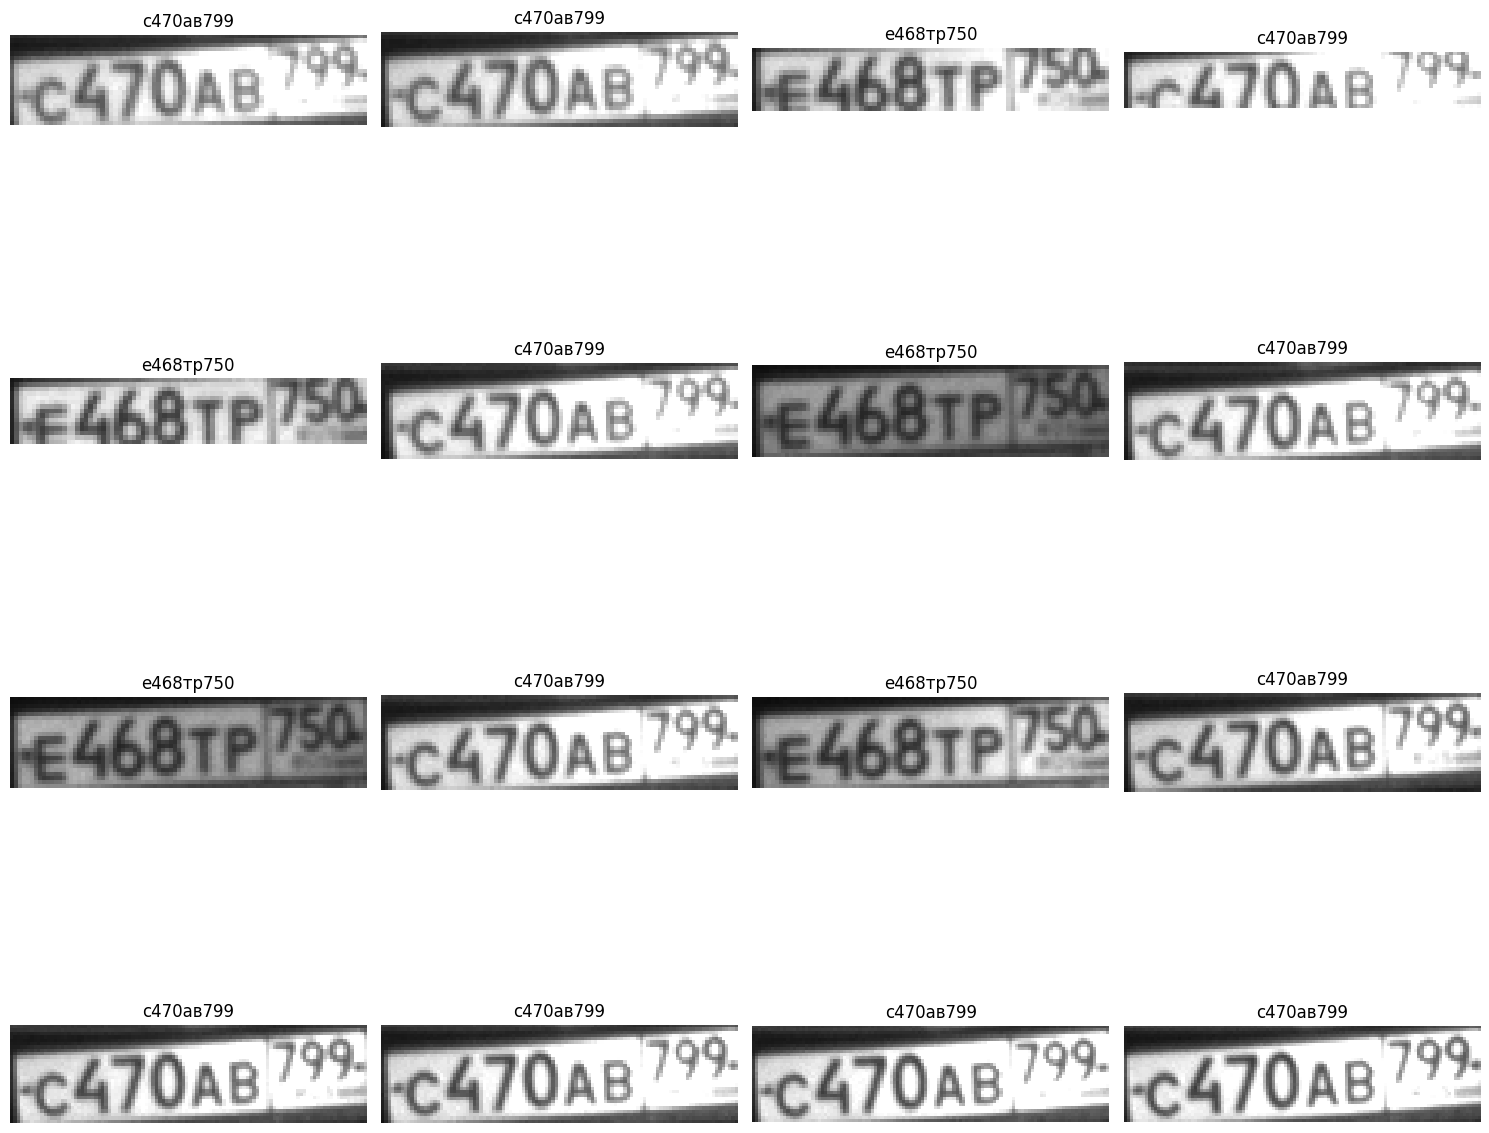

In [43]:
display_images_grid(paths, labels)

In [44]:
paths = [f'{root}/images/{fname}' for fname in df[df.is_valid == 0].filename.values[:16]]
labels = df[df.is_valid == 0].label.values[:16]

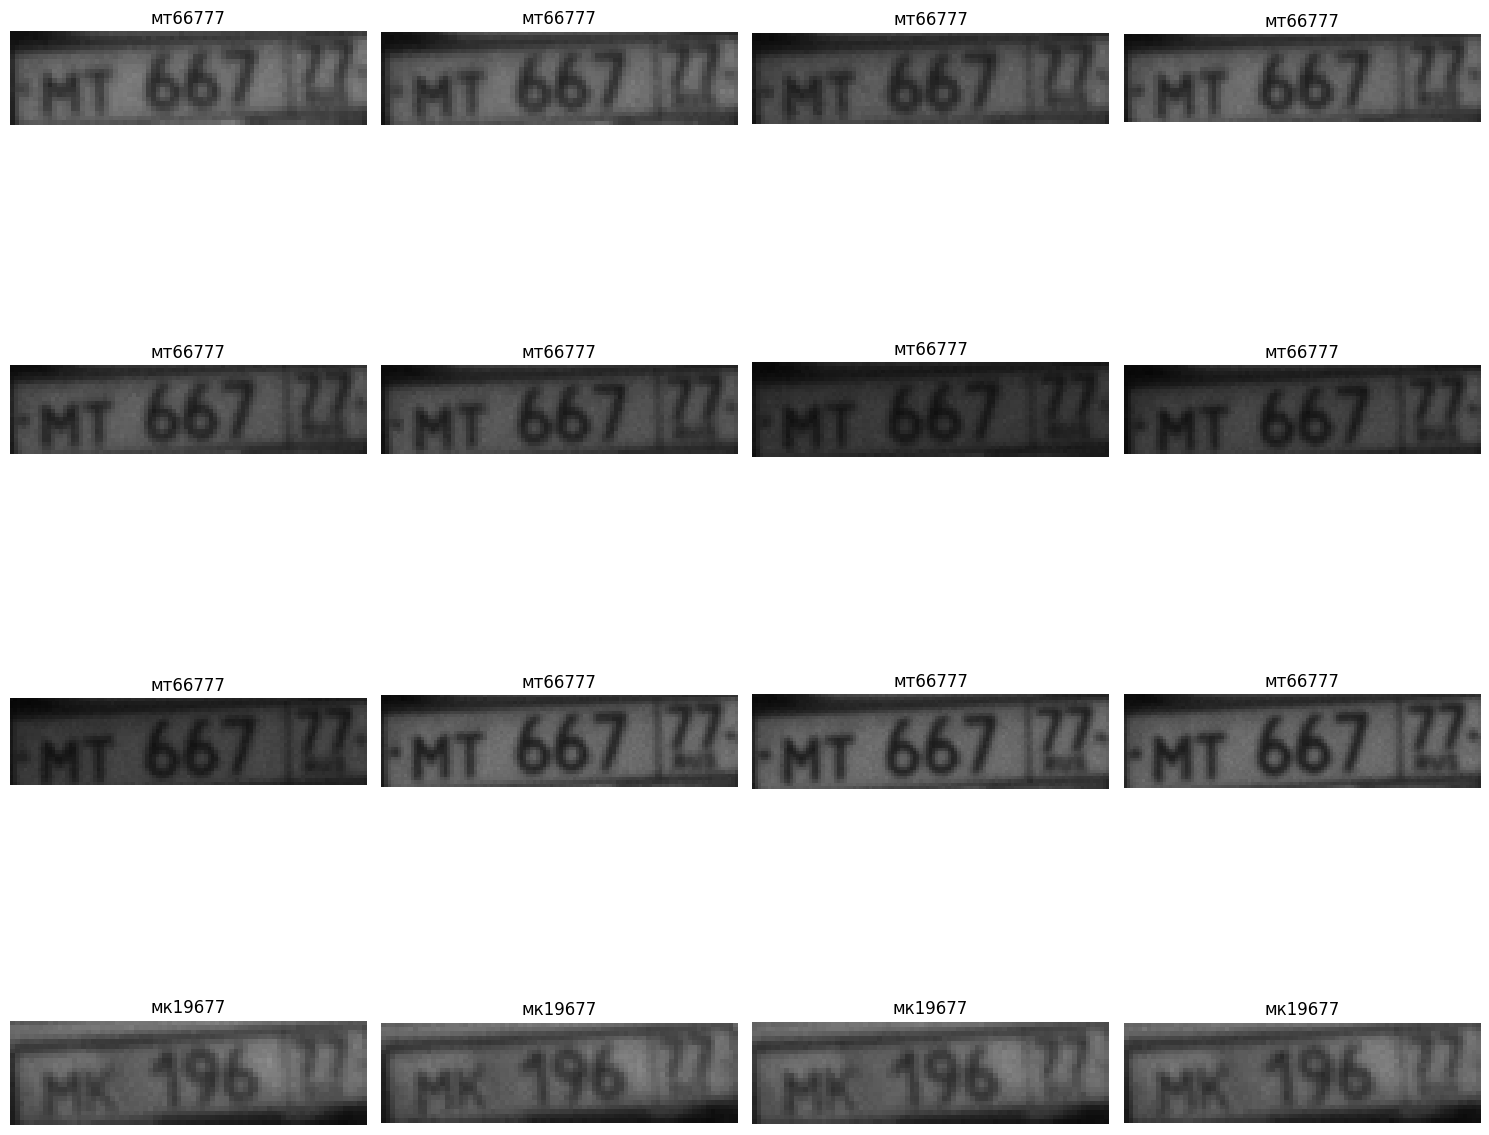

In [45]:
display_images_grid(paths, labels)

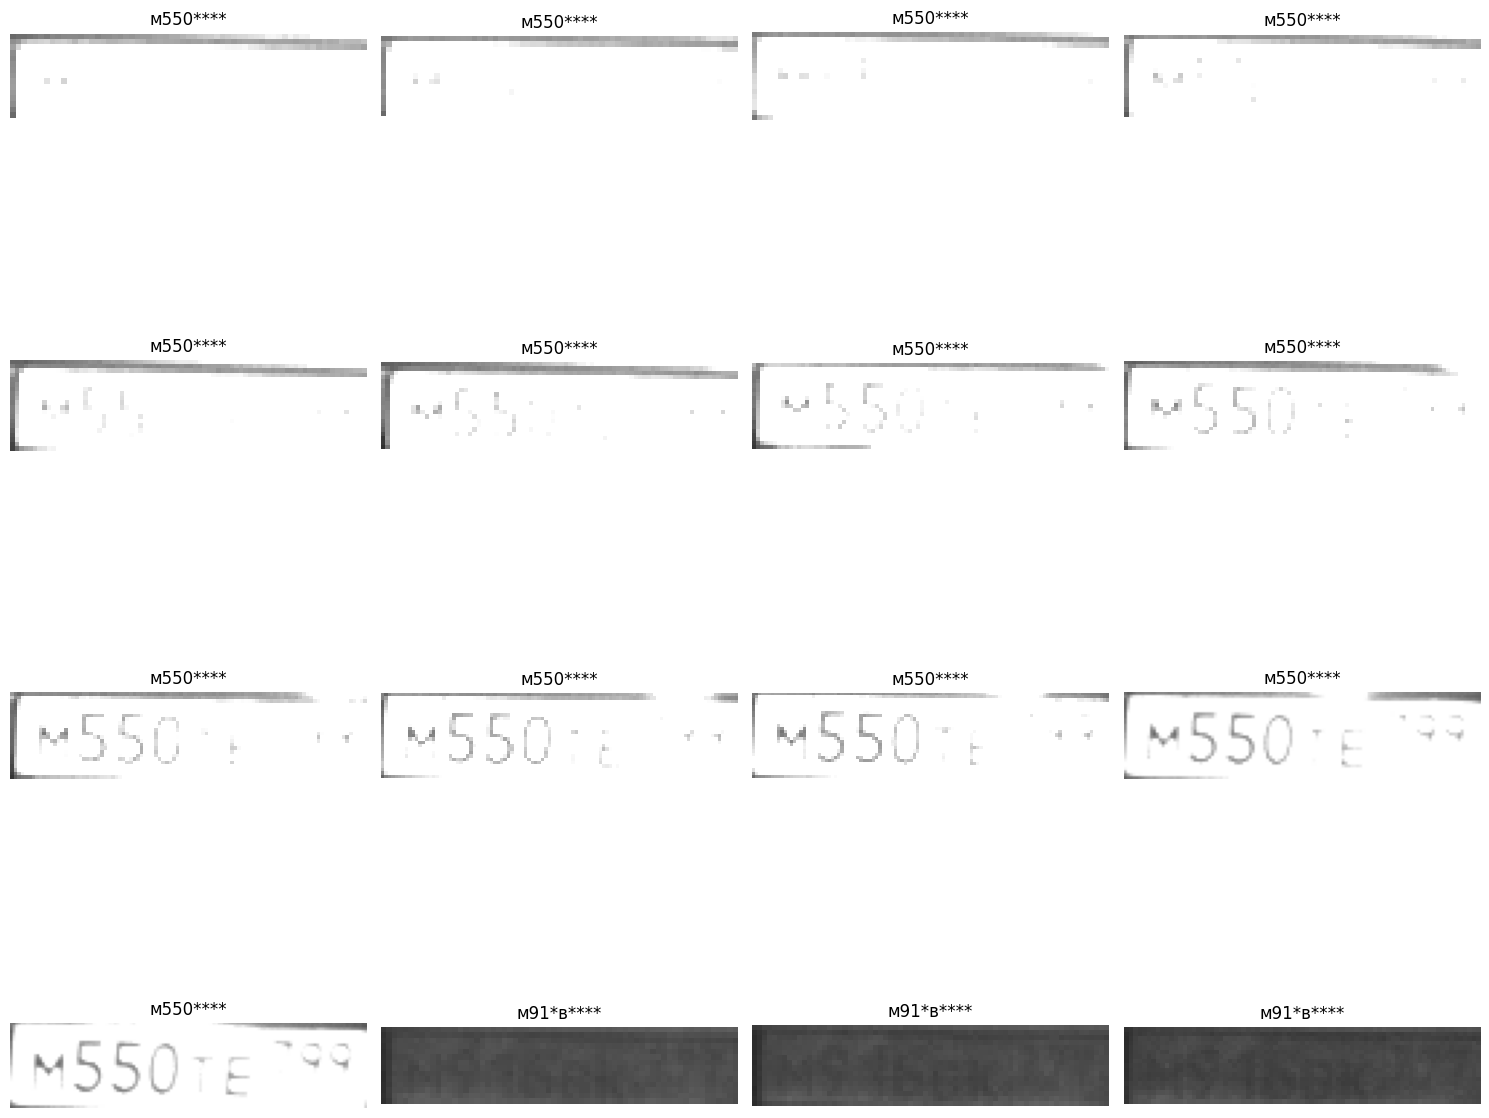

In [46]:
display_images_grid(
    [f'{root}/images/{fname}' for fname in df[df.label.apply(lambda s: '*' in s)].filename.values[:16]], 
    df[df.label.apply(lambda s: '*' in s)].label.values[:16]
)

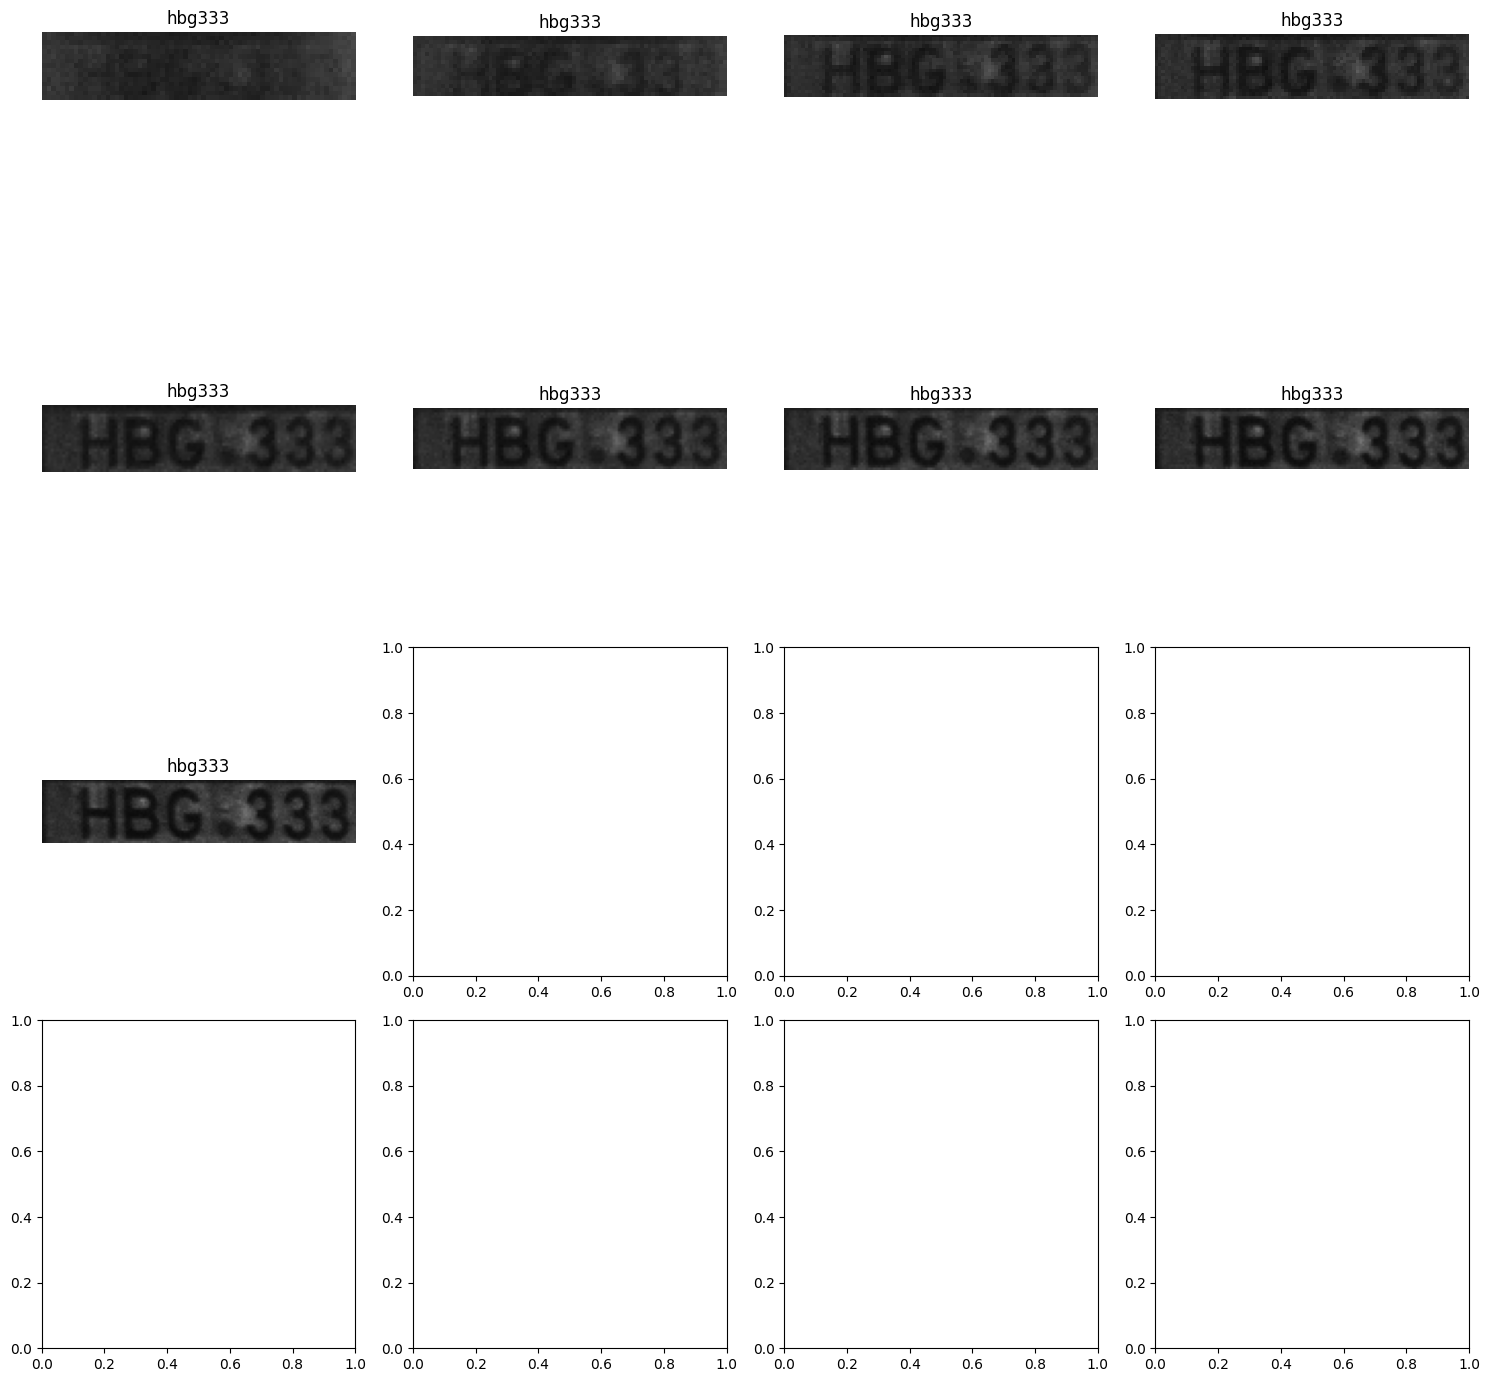

In [87]:
display_images_grid(
    [f'{root}/images/{fname}' for fname in df[df.label.apply(lambda s: 'h' in s)].filename.values[:16]], 
    df[df.label.apply(lambda s: 'h' in s)].label.values[:16]
)

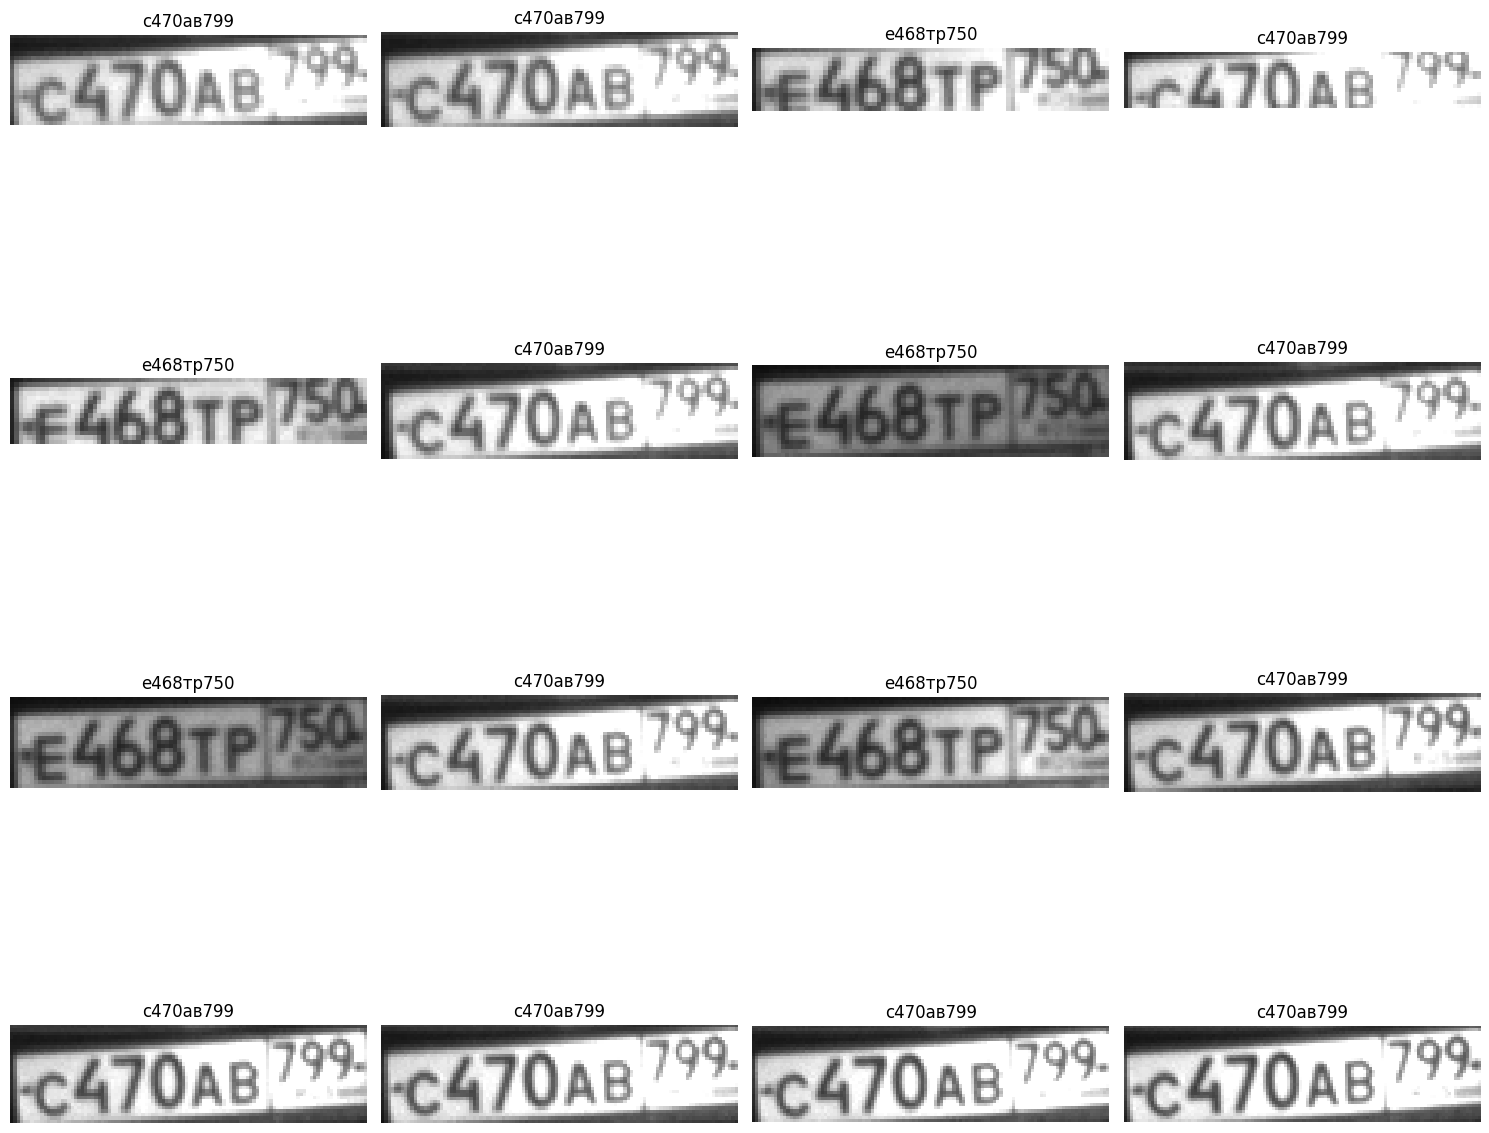

In [58]:
paths = [f'{root}/images/{fname}' for fname in df[df.is_valid == 1].filename.values[:16]]
labels = df[df.is_valid == 1].label.values[:16]
display_images_grid(paths, labels)

In [104]:
df = df[df.is_valid == 1].reset_index(drop=True)

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
car_ids = df.car_id.unique()

In [107]:
df.car_id.value_counts().describe()

count    1432.000000
mean       13.566341
std         8.200991
min         1.000000
25%         7.000000
50%        12.000000
75%        18.000000
max        76.000000
Name: car_id, dtype: float64

In [ ]:
df['filename'] = df['filename'].apply(lambda x: f'images/{x}')

In [195]:
train_car_ids, temp_car_ids = train_test_split(car_ids, test_size=0.25, random_state=42)
val_car_ids, test_car_ids = train_test_split(temp_car_ids, test_size=0.4, random_state=42)

In [196]:
train_df = df[df.car_id.isin(train_car_ids)]
val_df = df[df.car_id.isin(val_car_ids)]
test_df = df[df.car_id.isin(test_car_ids)]

In [198]:
train_df.to_csv(f'{root}/train.tsv', sep='\t', index=False)
val_df.to_csv(f'{root}/val.tsv', sep='\t', index=False)
test_df.to_csv(f'{root}/test.tsv', sep='\t', index=False)

In [199]:
"".join(sorted(set("".join(df.label.values))))

'0123456789авекмнорстух'

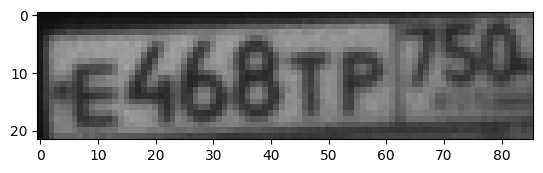

In [141]:
plt.imshow(image)

In [142]:
import albumentations as A

In [181]:
import numpy as np
class Contrast():
    def __init__(self, rng=None, islow=True):
        self.rng = rng or np.random.default_rng()
        self.islow = islow

    def __call__(self, img):
        img = img / 255.0
        if self.islow:
            c = self.rng.uniform(0.2, 0.9)
        else:
            c = self.rng.uniform(2, 10)
        means = np.mean(img, axis=(0, 1), keepdims=True)
        img = np.clip((img - means) * c + means, 0, 1) * 255
        return img.astype(np.uint8)

    def get_init_args_names(self) -> tuple[str, ...]:
        return ("islow",)

In [176]:
transforms = A.Compose([
    A.RandomBrightnessContrast(p=1, brightness_limit=0.3)
])

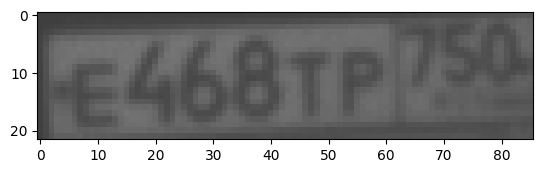

In [191]:
plt.imshow(Contrast()(image))

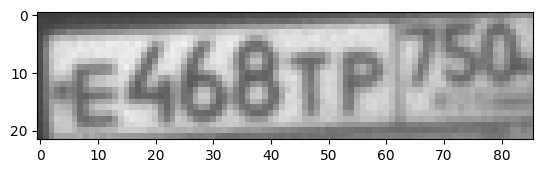

In [177]:
plt.imshow(transforms(image=image)['image'])

In [188]:
# df.to_csv('/mnt/nvme13TB/RAW_DATASETS/ocr_plates/imgs/train.tsv', sep='\t', index=False)